In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '291572',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/gTxav_KKQK1rDg-XuCjCSA__thumb/img/tFTOAKG5aDXxYfNRmJNmfyxH83M=/fit-in/200x150/filters:strip_icc()/pic5164812.jpg',
  'name': 'Oath: Chronicles of Empire and Exile',
  'yearpublished': '2021'},
 {'id': '341254',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/U4aoXbKATU7YbA8bAT73FQ__thumb/img/g0aac2-OQvMbEPXv1vIvSumPmkA=/fit-in/200x150/filters:strip_icc()/pic6253876.png',
  'name': 'Lost Ruins of Arnak: Expedition Leaders',
  'yearpublished': '2021'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 24)
page number = 20 (max: 100, len: 16)
page number = 30 (max: 100, len: 10)
page number = 40 (max: 100, len: 8)
page number = 50 (max: 100, len: 5)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 100, len: 1)
comments_df shape: (89466, 4)


,id,username,rating,value
0,291572,143245,N/A,playtest copy
1,291572,abernath,10,"Oh, Cole Wehrle, you clever devil. What a wild..."
2,291572,Across the Rhine,N/A,KS April 2021
3,291572,AgentDib,N/A,Preordered from Kickstarter Backerkit PMB 303 ...
4,291572,agundlachi,10,Kickstarter w/ deluxe components. Wonderful co...
...,...,...,...,...
89461,167791,z_zadar,9,Some games are so much fun. Others can be a li...
89462,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
89463,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
89464,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15065 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10         14888
9          14023
8          11592
7           6327
N/A         6260
           ...  
8.34667        1
9.9999         1
1.8            1
5.5555         1
7.72667        1
Name: rating, Length: 495, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(68141, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6260, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"An excellent game, but I must admit, it might not be for everyone.  This game is a time commitment for sure. Our group has been playing weekly for over a year now, and it feels like we hardly scratched the surface. Dedication is required!  The only thing keeping the game from the fabled '10' is the repetitiveness. Every mission feels like the same 'kill this', 'get that'. I don't mind, as every character feels much different from each other, and the main crux for me is the interaction between teammates.  Difficult to form into words, but it's a great game if you find the right mates to play it with."

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"Kickstarter. Card drafting / tableau building game where you draw villagers to place in your growing village. Trick is that the villagers that score the most points are rare and require a chain of many others played first. The rules are simple but the play is somewhat unsmooth. Lucky draw is a major thing. Getting the right card means everything, and not getting it will ruin the game. This can happen quite easily and you can't play the game hoping to get that one special card. You have to play with what's available now. That makes decisions and planning ahead somewhat superfluous. There's usually an obvious card to take. After the draft you always build as much as possible of what you got, there's no point in waiting. The player who gets the lucky picks more often than the others will usually win. I would have liked more strategy and less luck. It's still an okay game, but not great. I'll play it if in the mood."

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
34/34 - 4s - loss: 0.6356 - accuracy: 0.6641 - val_loss: 0.5533 - val_accuracy: 0.8262
Epoch 2/100
34/34 - 2s - loss: 0.5125 - accuracy: 0.8473 - val_loss: 0.4848 - val_accuracy: 0.8455
Epoch 3/100
34/34 - 2s - loss: 0.4378 - accuracy: 0.8519 - val_loss: 0.4185 - val_accuracy: 0.8469
Epoch 4/100
34/34 - 2s - loss: 0.3654 - accuracy: 0.8584 - val_loss: 0.3654 - val_accuracy: 0.8571
Epoch 5/100
34/34 - 2s - loss: 0.3105 - accuracy: 0.8810 - val_loss: 0.3397 - val_accuracy: 0.8646
Epoch 6/100
34/34 - 2s - loss: 0.2736 - accuracy: 0.8952 - val_loss: 0.3263 - val_accuracy: 0.8687
Epoch 7/100
34/34 - 2s - loss: 0.2427 - accuracy: 0.9061 - val_loss: 0.3198 - val_accuracy: 0.8714
Epoch 8/100
34/34 - 2s - loss: 0.2173 - accuracy: 0.9181 - val_loss: 0.3223 - val_accuracy: 0.8717
Epoch 9/100
34/34 - 2s - loss: 0.1951 - accuracy: 0.9272 - val_loss: 0.3272 - val_accuracy: 0.8704
Epoch 10/100
34/34 - 2s - loss: 0.1767 - accuracy: 0.9361 - val_loss: 0.3395 - val_accuracy: 0.8699
Epoch 11/

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000298876D6A90>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

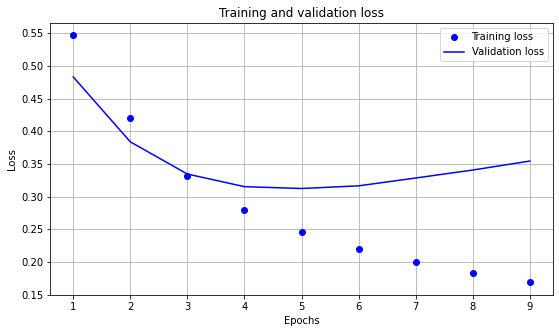

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

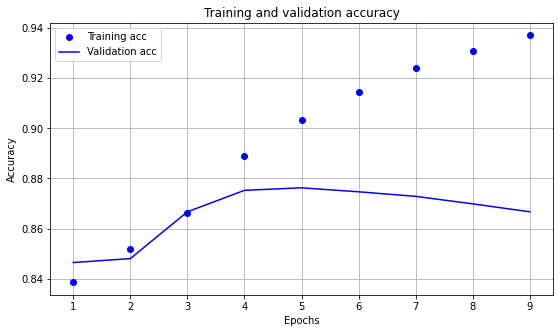

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"An excellent game, but I must admit, it might not be for everyone.  This game is a time commitment for sure. Our group has been playing weekly for over a year now, and it feels like we hardly scratched the surface. Dedication is required!  The only thing keeping the game from the fabled '10' is the repetitiveness. Every mission feels like the same 'kill this', 'get that'. I don't mind, as every character feels much different from each other, and the main crux for me is the interaction between teammates.  Difficult to form into words, but it's a great game if you find the right mates to play it with."
score: 1.000000
actual: 1

input:
"Kickstarter. Card drafting / tableau building game where you draw villagers to place in your growing village. Trick is that the villagers that score the most points are rare and require a chain of many others played first. The rules are simple but the play is somewhat unsmooth. Lucky draw is a major thing. Getting the right card means everything, 

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

7/7 - 0s
input:
"BGGCon 2016 purchase from Stronghold Games."
score: 0.000000

input:
"P1-5 B4 D3.41 T3 2nd hand, sleeved? RB not read Played 0 At Home With Expansion"
score: 1.000000

input:
"Kickstart backer and waiting anxiously...."
score: 1.000000

input:
"keep an eye out for the dice tower review new from the root/vast people. looks promising"
score: 0.000000

input:
"Played once. I love the game, and it is on my wish list."
score: 1.000000

input:
"Deluxe Edition BGG 2020 Secret Santa Gift"
score: 1.000000

input:
"includes Captain America, Ms. Marvel, and Green Goblin sets."
score: 1.000000

input:
"Kickstarter in 2020 Interest: Leder Games & Concept"
score: 1.000000

input:
"Standard cards (character ability and event cards): Number of cards: 727 If you don't want to sleeve all the cards, the order of priority should be: Character ability cards - 40 minimum to sleeve each player's active deck, 505 in total. Personal quest cards - 24 cards; Event cards - 150 cards.  mall cards 

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000029B3E295490>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.62


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 0.99


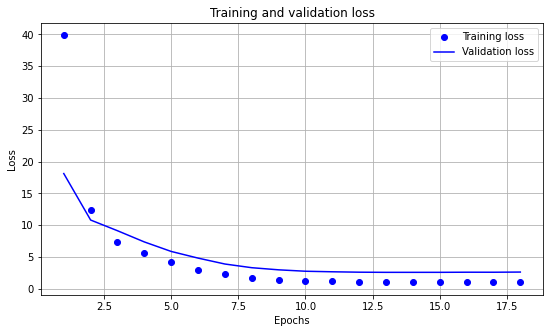

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

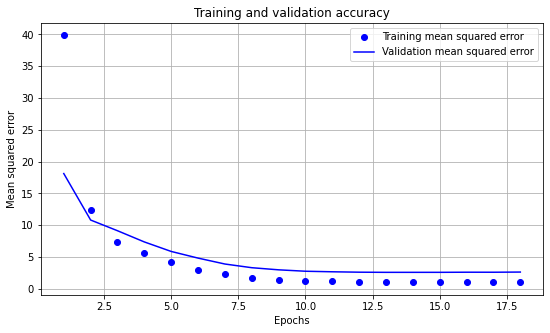

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"An excellent game, but I must admit, it might not be for everyone.  This game is a time commitment for sure. Our group has been playing weekly for over a year now, and it feels like we hardly scratched the surface. Dedication is required!  The only thing keeping the game from the fabled '10' is the repetitiveness. Every mission feels like the same 'kill this', 'get that'. I don't mind, as every character feels much different from each other, and the main crux for me is the interaction between teammates.  Difficult to form into words, but it's a great game if you find the right mates to play it with."
score: 9.11
actual: 9.30 

input: 
"Kickstarter. Card drafting / tableau building game where you draw villagers to place in your growing village. Trick is that the villagers that score the most points are rare and require a chain of many others played first. The rules are simple but the play is somewhat unsmooth. Lucky draw is a major thing. Getting the right card means everything

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Geek Bag Set Mayday Standard USA Game Purple MDG-7040"
    reg score: 9.77
    clf score: 1

"My wife got this for me and we really enjoyed playing it. Great engine builder that has neat “group hug” triggers. For example instead of hurting other players maybe everyone gets a bonus but you get a better bonus. Doesn’t leave anyone feeling a sting even if you are losing. Love the scoring and flow of the game. First impressions are good! Love the theme and components."
    reg score: 7.47
    clf score: 1

"Collectors Edition, played twice, like new."
    reg score: 7.32
    clf score: 1

"Includes the Leeghwater Project expansion"
    reg score: 8.68
    clf score: 1

"Bought digitally.   I normally prefer strategy (think 4X) over tactics, vastly so. However, Gloomhaven's two-card system is genuinely fun, and I really want to try Jaws of the Lion with friends soon.   The currently only mode in the digital version, "Guildmaster", is a pretty fun solo-only adaptation of the game, but it's 

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.36 |           3593 |
| 167355 |          8.41 |           1895 |
| 167791 |          8.21 |           8375 |
| 169427 |          8.67 |            260 |
| 169786 |          8.09 |           7405 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.12 |            319 |
| 167355 |          8.26 |            212 |
| 167791 |          8.25 |            442 |
| 169427 |          8.45 |             74 |
| 169786 |          8.14 |            598 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/gTxav_K...","<a href=""https://boardgamegeek.com/boardgame/2...",7.774053,8.128921,7.869902,1,2021
1,"<img src=""https://cf.geekdo-images.com/U4aoXbK...","<a href=""https://boardgamegeek.com/boardgame/3...",NaN,8.063975,NaN,2,2021
2,"<img src=""https://cf.geekdo-images.com/bwABghR...","<a href=""https://boardgamegeek.com/boardgame/3...",9.666667,8.614496,9.140581,3,2021
3,"<img src=""https://cf.geekdo-images.com/cpVKg0C...","<a href=""https://boardgamegeek.com/boardgame/2...",6.105263,7.661940,6.375990,4,2021
4,"<img src=""https://cf.geekdo-images.com/fW43z5X...","<a href=""https://boardgamegeek.com/boardgame/3...",6.514620,7.947869,6.904952,5,2021


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Oath: Chronicles of Empire and Exile,7.774053,8.128921,7.869902,1,2021
2,,Lost Ruins of Arnak: Expedition Leaders,NaN,8.063975,NaN,2,2021
3,,Gloomholdin',9.666667,8.614496,9.140581,3,2021
4,,Wild Assent,6.105263,7.661940,6.375990,4,2021
5,,Terraforming Mars: Ares Expedition,6.514620,7.947869,6.904952,5,2021


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Gloomholdin',9.666667,8.614496,9.140581,3,2021
2,,Coalitions,9.000000,9.412749,9.137583,9,2022
3,,Eclipse: Second Dawn for the Galaxy,8.720785,8.127649,8.631276,49,2020
4,,Brass: Birmingham,8.669664,8.174242,8.625328,21,2018
5,,Middara: Unintentional Malum – Act 1,8.666078,8.452379,8.618731,40,2019


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Gloomholdin',9.666667,8.614496,9.140581,3,2021
2,,Coalitions,9.000000,9.412749,9.137583,9,2022
3,,6: Siege – The Board Game,8.250000,9.539097,8.745807,33,2022
4,,Eclipse: Second Dawn for the Galaxy,8.720785,8.127649,8.631276,49,2020
5,,Brass: Birmingham,8.669664,8.174242,8.625328,21,2018


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"A little to convoluted for my tastes. I will play this if everyone else want to get it to the table. Wonderful presentation though."
score: 5.63

"- Marvel Champions: The Card Game – Venom Hero Pack - Marvel Champions: The Card Game – Nebula Hero Pack"
score: 5.97

"-Double Sided Fall/Winter Playmat -Double Sided Mountain/River Playmat -The Clockwork Expansion -Exiles and Partisans Deck -Resin Clearing Markers -Extra Vagabonds -Upgrade Kit"
score: 5.98

"Entscheiden Sie über das Schicksal des Waldes, während die Waldfraktionen für gegensätzliche Ziele kämpfen.  1-6 Spieler / Experten Spiel"
score: 6.54

"I'm really enjoying this game from a favorite designer. Plays fast which offsets the randomness of the card draw. Lots of interesting decisions. Much deeper than it first appears."
score: 6.56

"I keep avoiding this game. I need to play it. If nothing else to see if I'll enjoy it. I just feel 6-12 hours to dedicate to one game is a lot."
score: 6.62

"Have not played yet, but from rea

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test